In [1]:
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, auc,confusion_matrix,precision_score,recall_score,f1_score
#from sklearn.metrics import plot_confusion_matrix

In [2]:
from textblob import TextBlob

# Use TextBlob
def textblob_tokenizer(str_input):
    blob = TextBlob(str_input.lower())
    tokens = blob.words
    words = [token.stem() for token in tokens]
    return words

In [3]:
stop_words = set(nltk.corpus.stopwords.words("english"))
with open('dems.txt', 'r',encoding='UTF8') as file:
    dem_text = [line.strip('\n') for line in file]

with open('gop.txt', 'r',encoding='UTF8') as file:
    gop_text = [line.strip('\n') for line in file]

vectorizer = CountVectorizer(input=dem_text + gop_text,stop_words=stop_words,max_features=1000,tokenizer=textblob_tokenizer)
dem_bow = vectorizer.fit_transform(dem_text)
gop_bow = vectorizer.fit_transform(gop_text)

C:\Users\pavan\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [4]:
col=vectorizer.get_feature_names()
df_D=pd.DataFrame(data=dem_bow.toarray(),columns=col)
df_D['class']=0
df_R=pd.DataFrame(data=gop_bow.toarray(),columns=col)
df_R['class']=1
df=df_D.append(df_R, ignore_index=True)


In [5]:
#Consider only Alphabets and words with length >3
df_columns=[]
for i in df.columns:
    if(len(i)>3 and i.isalpha()):
        df_columns.append(i)
df=df[df_columns]
df_summ=df.describe().transpose()
df_summ.to_csv('summ.csv')

In [6]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
X = df.iloc[:,0:df.shape[1]-1]
y = df.iloc[:,-1]   
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  
print(featureScores.nlargest(10,'Score'))  #print 10 best features

          Specs       Score
587     program  807.047433
831       women  357.053008
438  leadership  302.661827
351        high  134.874239
439       learn  134.481972
353     highest   71.345699
364        host   70.797387
541    particip   67.055381
348        held   60.262073
397      inspir   58.587363


In [7]:
df.shape

(38351, 843)

In [8]:
X = df.loc[:, df.columns != 'class']  # Features
y = df['class'] 

In [16]:
#PCA
pca=PCA()
principalComponents=pca.fit_transform(X)
principalDf=pd.DataFrame(data=principalComponents)
principalDf
X_p = principalDf # Features
y = df['class'] 

In [17]:
explained_variance = pca.explained_variance_ratio_
#explained_variance

In [18]:
# 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
tsne = TSNE()
X_t = tsne.fit_transform(X)

In [ ]:
sns.scatterplot(X_t[:,0], X_t[:,1], hue=y, legend='full')

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [10]:
models = []
# models.append(('Logistic Regression', LogisticRegression(solver='lbfgs',C=100,max_iter=5000)))
# models.append(('KNN', KNeighborsClassifier(n_neighbors=8,p=1,metric='minkowski',weights='distance')))
# models.append(('DecisionTree', DecisionTreeClassifier(criterion="entropy",max_depth=3,random_state=0)))
# models.append(('RAN', RandomForestClassifier(criterion='entropy',n_estimators=1000,random_state=0)))
models.append(('Naive Bayes', MultinomialNB()))
#models.append(('Support Vector Machine', SVC(gamma='scale',kernel='rbf',C=10)))

In [40]:
for name,model in models:
    model.fit(X_train,y_train)    
    y_pred=model.predict(X_test)
    correct = (y_test == y_pred).sum()
    incorrect = (y_test != y_pred).sum()
    accuracy = correct / (correct + incorrect) * 100
    print(name,accuracy)

Naive Bayes 94.53328698070573


In [41]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
Y_mnb_score = mnb.predict_proba(X_test)
Y_mnb = mnb.predict(X_test)
correct = (y_test == y_pred).sum()
incorrect = (y_test != y_pred).sum()
accuracy = correct / (correct + incorrect) * 100
fpr_mnb, tpr_mnb, thresholds_mnb = roc_curve(y_test, Y_mnb_score[:, 1])
roc_auc=metrics.auc(fpr_mnb, tpr_mnb)

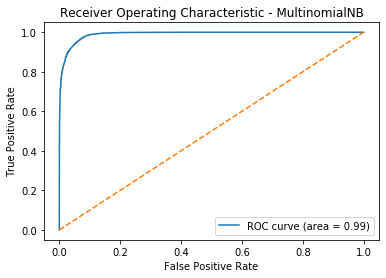

In [42]:
#plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - MultinomialNB')
plt.plot(fpr_mnb, tpr_mnb,label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], ls="--")
#plt.plot([0, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [55]:
a=confusion_matrix(y_test, Y_mnb)
a

array([[5502,  295],
       [ 334, 5375]], dtype=int64)

In [44]:
#from sklearn.metrics import plot_confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

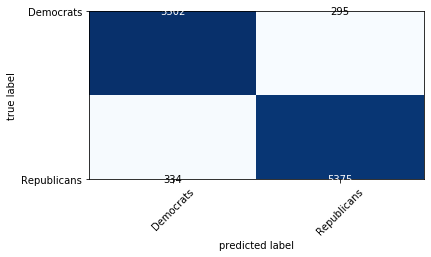

In [45]:
import matplotlib.pyplot as plt
class_names=["Democrats","Republicans"]
fig,ax_ = plot_confusion_matrix(a,cmap=plt.cm.Blues,class_names=class_names)
#disp.ax_.set_title('Normalized Confusion Matrix')

#print('Normalized Confusion Matrix')
#print(disp.confusion_matrix)
plt.show()

In [46]:
roc_auc=metrics.auc(fpr_mnb, tpr_mnb)

In [47]:
roc_auc

0.9904655143078246

In [48]:
precision_score(y_test, y_pred)

0.9479717813051146

In [49]:
recall_score(y_test, y_pred)

0.9414958836924154

In [52]:
f1_score(y_test, y_pred)

0.9447227348624659

In [ ]:

Accuracy: 94.53
Precision: 0.94797
Recall: 0.94149
F1 score: 0.94472
ROC AUC: 0.99046
[[5502,  295],
 [ 334, 5375]]

